# NLP - Personality Analysis
## Task 1
We want to explore the general trend of the conversation data. For this purpose, create a dataframe for each speaker by gathering all his utterances in a single file. Then write a script that determines the vocabulary set, vocabulary size, total number of tokens, total number of repetitions of words in the same post, total number of confirmation words (e.g., yes, OK, sure), total number of negation tokens, associated to each speaker. Summarize the result in a table, and then draw a subgraph that shows on the same plot the evolution of number of repetitions, number of negation, number of confirmation-like tokens, with respect to the number of tokens employed for each speaker (You may create some subdivision from the total number of tokens to ensure enough datum are used to represent the graphical illustration). Calculate the overall personality for each speaker by averaging over all instances of the original dataset, and comment on possible similarities and differences between speakers and whether some attributes are more associated with some personality patterns.

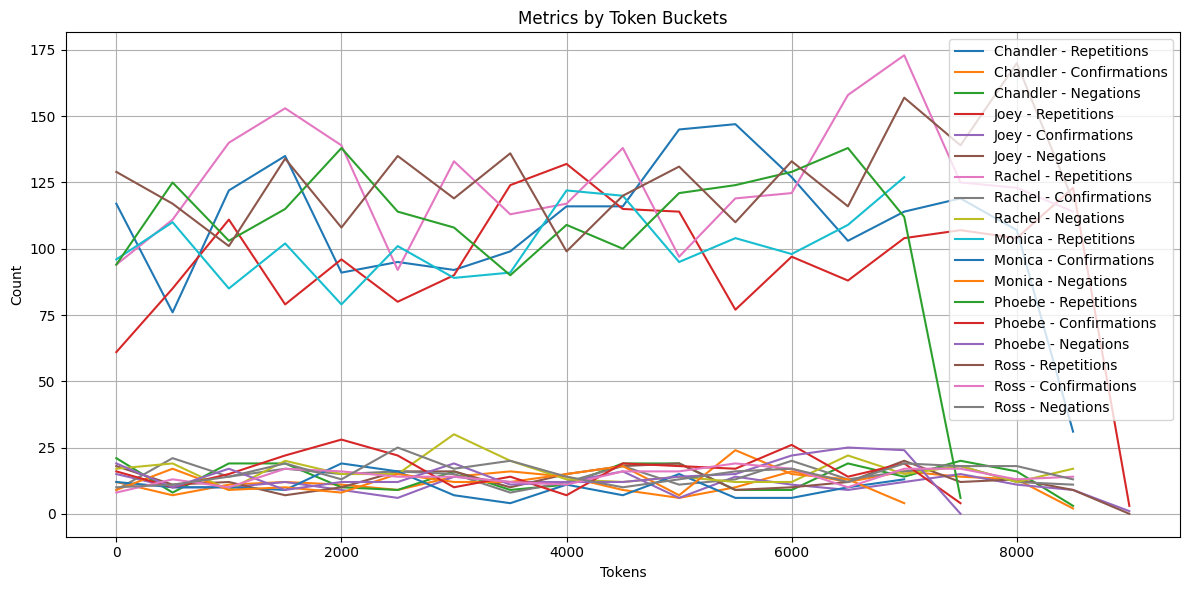

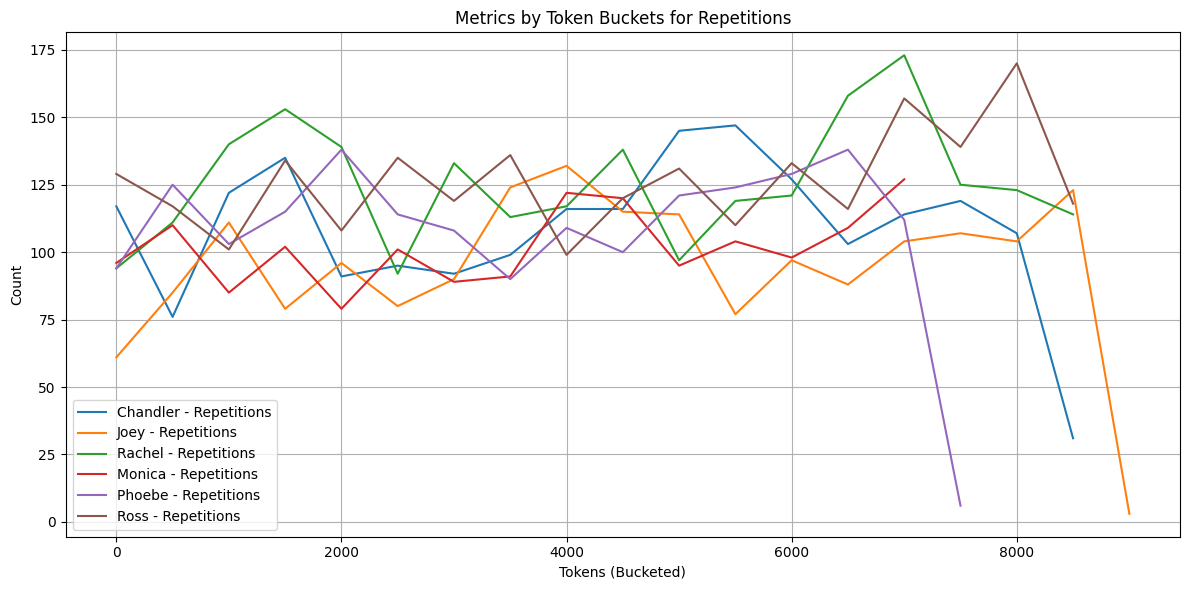

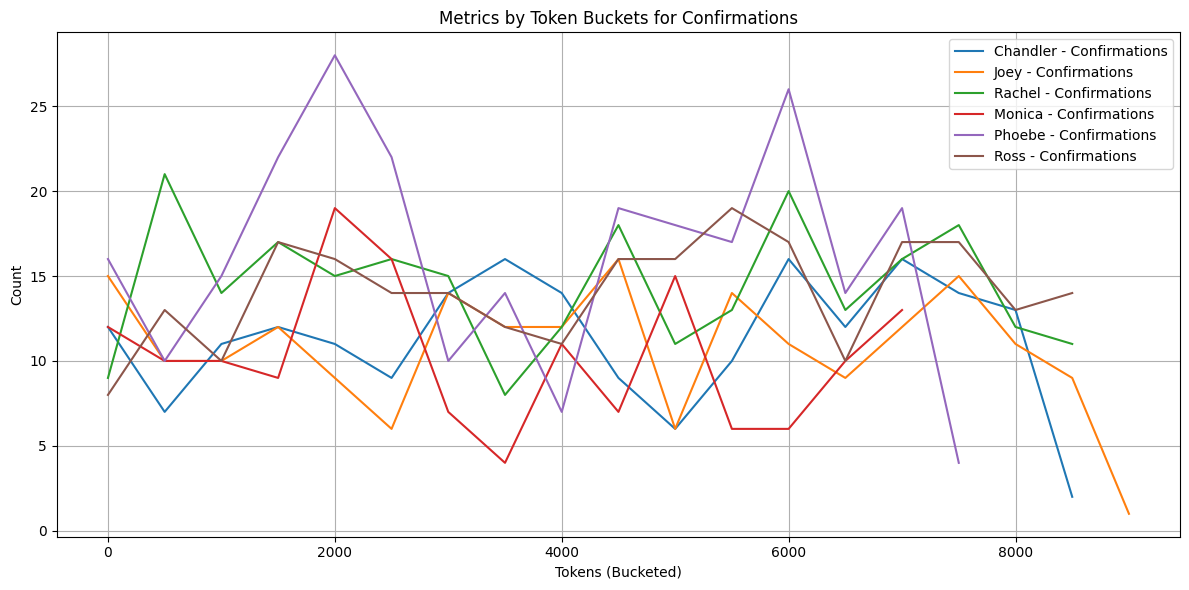

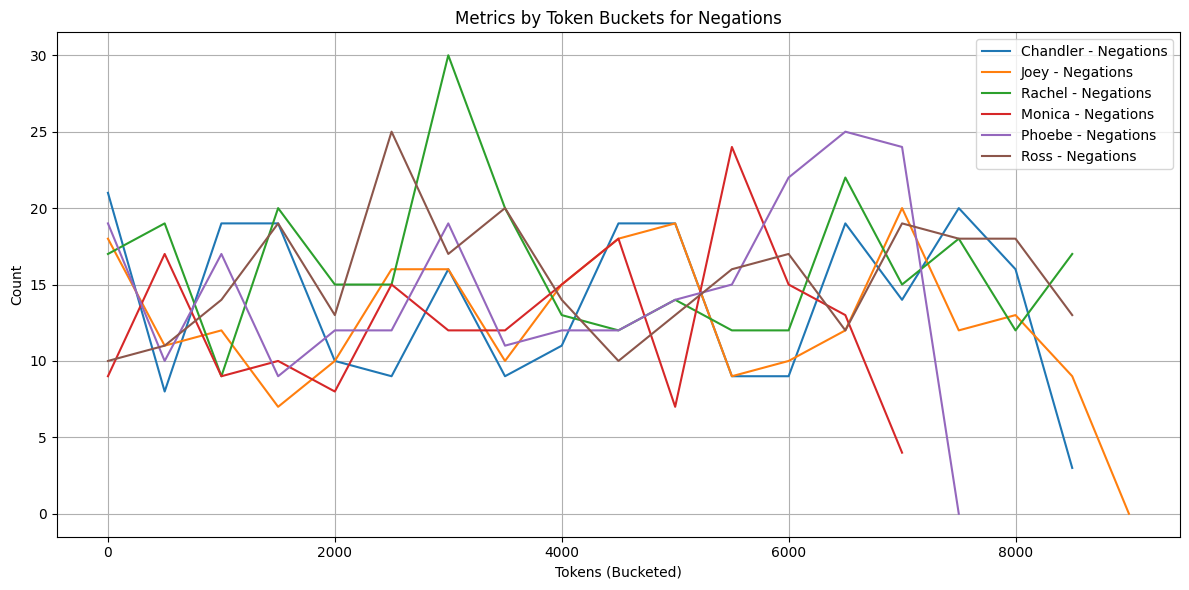

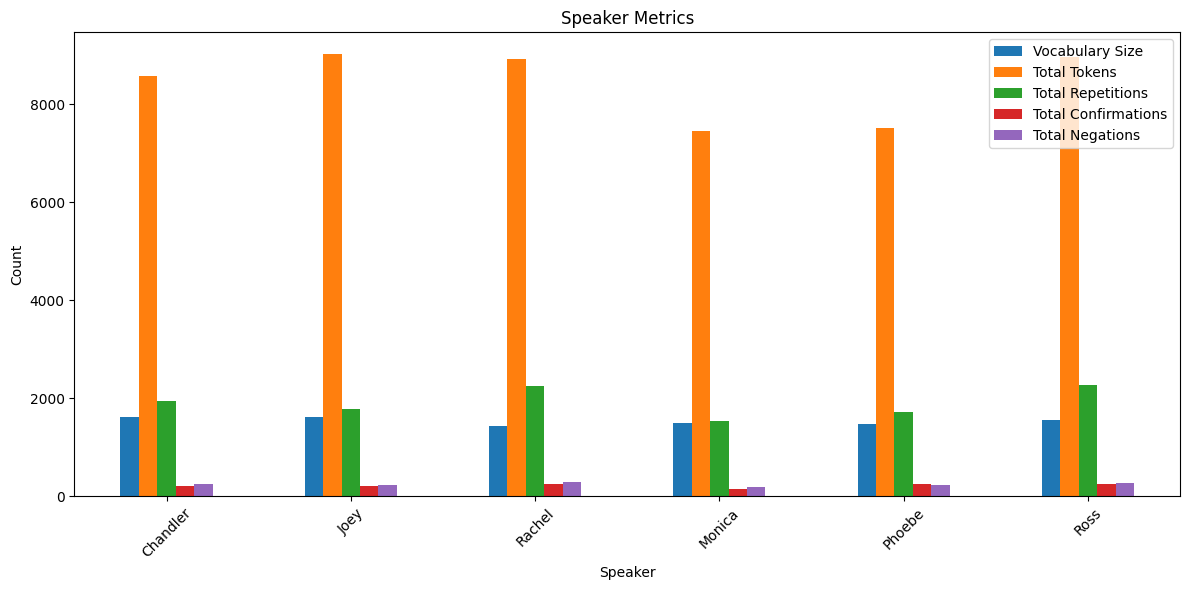

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np
import ast

# Define your words sets
confirmation_words = {'ok', 'yes', 'yeah', 'yep', 'okay', 'alright', 'sure', 'absolutely', 'certainly', 'of course', 'indeed', 'definitely'}
negation_words = {'no', 'not', 'never', 'none', 'nor', 'nobody', 'neither',
                  "don't", "isn't", "wasn't", "weren't", "doesn't", "won't", "haven't",
                  "don", "isn", "wasn", "weren", "doesn", "won", "haven",
                  "dont", "isnt", "wasnt", "werent", "doesnt", "wont", "havent"}
stop_words = {'the', 't', 's', 'a', 'to', 'is', 'and'}


def preprocess(sentence):
    tokens = sentence.split()
    return [
        token.translate(str.maketrans('', '', string.punctuation)).lower()
        for token in tokens if token not in stop_words
    ]


def calculate_row_metrics(speaker_df):
    speaker_df['Tokens'] = None
    speaker_df['Repetitions'] = None
    speaker_df['Confirmations'] = None
    speaker_df['Negations'] = None

    # Metrics per row
    for index, row in speaker_df.iterrows():
        tokens = preprocess(row['Utterance_1'])
        word_counts = Counter(tokens)

        confirmation_count = sum(count for word, count in word_counts.items() if word in confirmation_words)
        negation_count = sum(count for word, count in word_counts.items() if word in negation_words)

        U1_3_tokens = preprocess(row['Utterance_1'] + ' ' + row['Utterance_3'])
        U1_3_word_counts = Counter(U1_3_tokens)
        repetition_count = sum(count - 1 for word, count in U1_3_word_counts.items() if count > 1)
                
        # Assign calculated values to corresponding columns
        speaker_df.at[index, 'Tokens'] = tokens
        speaker_df.at[index, 'Repetitions'] = repetition_count
        speaker_df.at[index, 'Confirmations'] = confirmation_count
        speaker_df.at[index, 'Negations'] = negation_count

    return speaker_df


def calculate_overall_metrics(speaker_df):

    tokens = [token for sublist in speaker_df['Tokens'].values for token in sublist]
    total_tokens = len(tokens)
    
    vocabulary_set = set(tokens)
    vocabulary_size = len(vocabulary_set)

    total_repetitions = sum(speaker_df['Repetitions'].values)
    total_confirmations = sum(speaker_df['Confirmations'].values)
    total_negations = sum(speaker_df['Negations'].values)
    
    metrics = {}
    metrics['Vocabulary Size'] = vocabulary_size
    metrics['Total Tokens'] = total_tokens
    metrics['Total Repetitions'] = total_repetitions
    metrics['Total Confirmations'] = total_confirmations
    metrics['Total Negations'] = total_negations
    
    return metrics


def calculate_bucket_metrics(speaker_df, bucket_size=500):
    # Cumulative token counter
    cumulative_tokens = 0
    bucket_metrics = {
        'Bucket': [],
        'Repetitions': [],
        'Confirmations': [],
        'Negations': []
    }
    
    current_bucket = 0
    bucket_repetitions = 0
    bucket_confirmations = 0
    bucket_negations = 0

    for _, row in speaker_df.iterrows():
        # Get counts for this utterance
        token_size = len(row['Tokens'])
        cumulative_tokens += token_size

        # If we're in the same bucket, keep adding
        while cumulative_tokens > (current_bucket + 1) * bucket_size:
            # Save current bucket metrics
            bucket_metrics['Bucket'].append(current_bucket * bucket_size)
            bucket_metrics['Repetitions'].append(bucket_repetitions)
            bucket_metrics['Confirmations'].append(bucket_confirmations)
            bucket_metrics['Negations'].append(bucket_negations)
            
            # Reset metrics for the next bucket
            current_bucket += 1
            bucket_repetitions = 0
            bucket_confirmations = 0
            bucket_negations = 0

        # Add current row metrics to current bucket
        bucket_repetitions += row['Repetitions']
        bucket_confirmations += row['Confirmations']
        bucket_negations += row['Negations']

    # Add last bucket if not empty
    if bucket_repetitions > 0 or bucket_confirmations > 0 or bucket_negations > 0:
        bucket_metrics['Bucket'].append(current_bucket * bucket_size)
        bucket_metrics['Repetitions'].append(bucket_repetitions)
        bucket_metrics['Confirmations'].append(bucket_confirmations)
        bucket_metrics['Negations'].append(bucket_negations)
    
    return pd.DataFrame(bucket_metrics)


def calculate_average_personality(speaker_df):
    speaker_df['Personality'] = speaker_df['Personality'].apply(ast.literal_eval)
    personality_df = pd.DataFrame(speaker_df['Personality'].tolist(), columns=['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism'])
    return personality_df.mean()


def plot_charts(metrics_df, buckets_df):
    merged_df = pd.DataFrame()
    for user, df in buckets_df.items():
        df = df.set_index('Bucket')
        df = df.add_prefix(f"{user} - ")
        
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')

    merged_df.plot(kind='line', figsize=(12, 6))
    plt.title('Metrics by Token Buckets')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    df_repetitions = merged_df.filter(regex='- Repetitions$')
    df_repetitions.plot(kind='line', figsize=(12, 6))
    plt.title(f'Metrics by Token Buckets for Repetitions')
    plt.xlabel('Tokens (Bucketed)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    df_repetitions = merged_df.filter(regex='- Confirmations$')
    df_repetitions.plot(kind='line', figsize=(12, 6))
    plt.title(f'Metrics by Token Buckets for Confirmations')
    plt.xlabel('Tokens (Bucketed)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    df_repetitions = merged_df.filter(regex='- Negations$')
    df_repetitions.plot(kind='line', figsize=(12, 6))
    plt.title(f'Metrics by Token Buckets for Negations')
    plt.xlabel('Tokens (Bucketed)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    metrics_df = pd.DataFrame(metrics_df).T
    metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Speaker Metrics')
    plt.ylabel('Count')
    plt.xlabel('Speaker')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Load the data
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)

# Create a dictionary of DataFrames (each subset is a copy of the relevant data)
speakers = df['Speaker_1'].unique()
speaker_dfs = {speaker: df[df['Speaker_1'] == speaker].copy() for speaker in speakers}

metrics_df = {}
buckets_df = {}
personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in speaker_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    metrics = calculate_overall_metrics(speaker_df)
    metrics_df[speaker] = metrics

    bucket_df = calculate_bucket_metrics(speaker_df)
    buckets_df[speaker] = bucket_df

    personality_avg = calculate_average_personality(speaker_df)
    personality_averages[speaker] = personality_avg


# Plotting
plot_charts(metrics_df, buckets_df)

In [ ]:
averages = pd.DataFrame(personality_averages).T
averages.columns = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
averages

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
Chandler,0.648,0.375,0.386,0.580,0.477
Joey,0.574,0.614,0.297,0.545,0.455
Rachel,0.635,0.354,0.521,0.552,0.469
Monica,0.713,0.457,0.457,0.660,0.511
Phoebe,0.600,0.480,0.310,0.460,0.560
Ross,0.722,0.489,0.600,0.533,0.356


## Task 2
We want to evaluate the extent to which a speaker changes topic during conversation. In an attempt to quantify this generic trend, we hypothesize this is the case if the speaker quickly introduces new vocabulary and yields higher number of topics. To test this hypothesis, suggest a script that plots the evolution of the vocabulary size with respect to the number of tokens employed (draw on the same plot the distribution of each speaker), then comment on the suitability of the approach to discriminate key personality traits. To test the second aspect, suggest a script that uses the LDA to determine the optimal number of topics using global measures such as coherence and perplexity. You may inspire from tutoring such as Demystifying Topic Modeling Techniques in NLP | by Vijay Choubey | Medium. Similarly, comment on the suitability of the approach to highlight some personality traits.

### Part 1: Vocabulary Growth per Token

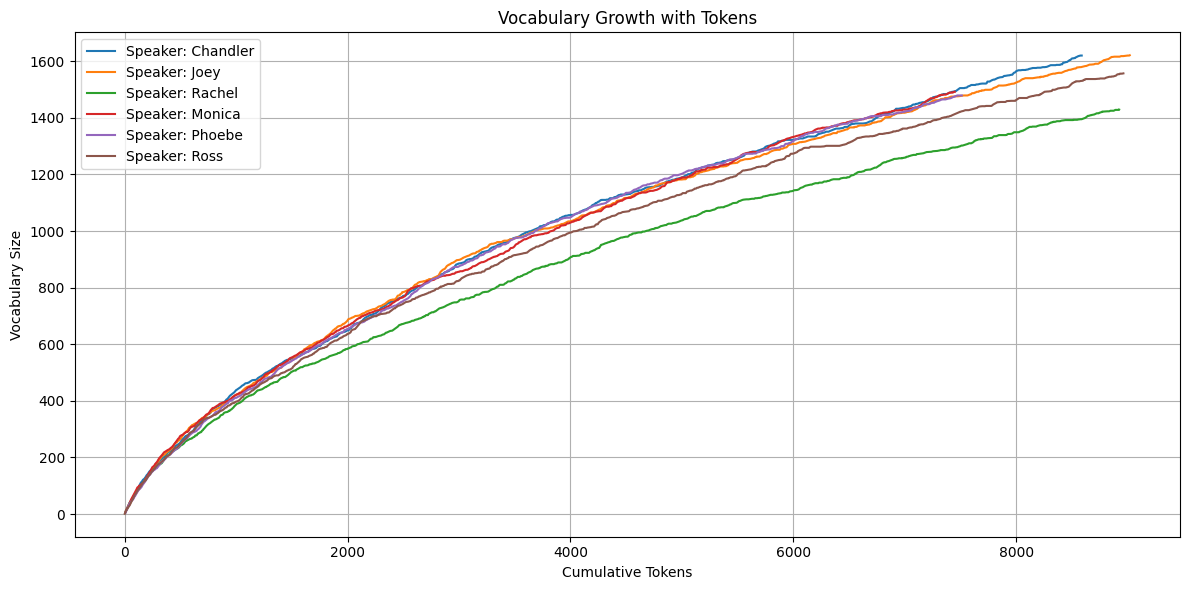

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split


# Function to calculate cumulative vocabulary growth with respect to tokens
def calculate_vocabulary_growth(speaker_df):
    cumulative_tokens = 0
    cumulative_vocabulary = set()
    vocabulary_growth = {'Tokens': [], 'Vocabulary': []}

    for _, row in speaker_df.iterrows():
        tokens = row['Tokens']
        cumulative_tokens += len(tokens)
        
        # Update vocabulary with new tokens
        cumulative_vocabulary.update(tokens)
        vocabulary_size = len(cumulative_vocabulary)

        # Append cumulative data
        vocabulary_growth['Tokens'].append(cumulative_tokens)
        vocabulary_growth['Vocabulary'].append(vocabulary_size)

    return pd.DataFrame(vocabulary_growth)

# Plot vocabulary growth for each speaker
plt.figure(figsize=(12, 6))
for speaker, speaker_df in speaker_dfs.items():
    vocab_growth_df = calculate_vocabulary_growth(speaker_df)
    plt.plot(vocab_growth_df['Tokens'], vocab_growth_df['Vocabulary'], label=f'Speaker: {speaker}')
    
plt.title(f'Vocabulary Growth with Tokens')
plt.xlabel('Cumulative Tokens')
plt.ylabel('Vocabulary Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Part 2: LDA Topic Modeling and Plotting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

# Function to perform LDA topic modeling using gensim
def lda_topic_modeling(tokens_list, num_topics):
    # Create a dictionary and corpus for gensim
    dictionary = corpora.Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    
    # Create an LDA model
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

    # Calculate coherence
    coherence_model = CoherenceModel(model=lda, texts=tokens_list, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()

    # Get topics
    topics = lda.print_topics(num_words=10)
    topics_dict = {f"Topic {i+1}": topic for i, topic in enumerate(topics)}

    return coherence, topics_dict

# Function to find the optimal number of topics
def find_optimal_topics(tokens_list, min_topics=2, max_topics=10):
    coherences = []

    for num_topics in range(min_topics, max_topics + 1):
        coherence, _ = lda_topic_modeling(tokens_list, num_topics)
        coherences.append(coherence)
    
    return coherences


best_topics_dict = {}
all_coherences = {}

# Applying LDA and plotting for each speaker
for speaker, speaker_df in speaker_dfs.items():
    tokens_list = speaker_df['Tokens']
    coherences = find_optimal_topics(tokens_list)
    topic_range = list(range(2, len(coherences) + 2))
    
    all_coherences[speaker] = coherences

    # Determine the best number of topics based on coherence
    best_index = np.argmax(coherences)
    print(f"Optimal number of topics for {speaker}: {topic_range[best_index]} with Coherence: {coherences[best_index]}")

    # Get topics for the best model
    best_num_topics = topic_range[best_index]
    _, best_topics = lda_topic_modeling(tokens_list, best_num_topics)
    best_topics_dict[speaker] = best_topics


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

Optimal number of topics for Chandler: 4 with Coherence: 0.3429482316036089


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

Optimal number of topics for Joey: 2 with Coherence: 0.3911188694196976


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

Optimal number of topics for Rachel: 5 with Coherence: 0.4196163300877644


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

Optimal number of topics for Monica: 3 with Coherence: 0.3550623645062621


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

Optimal number of topics for Phoebe: 6 with Coherence: 0.39376387787833567


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

Optimal number of topics for Ross: 4 with Coherence: 0.38963988829352547


/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mohammadrad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl'

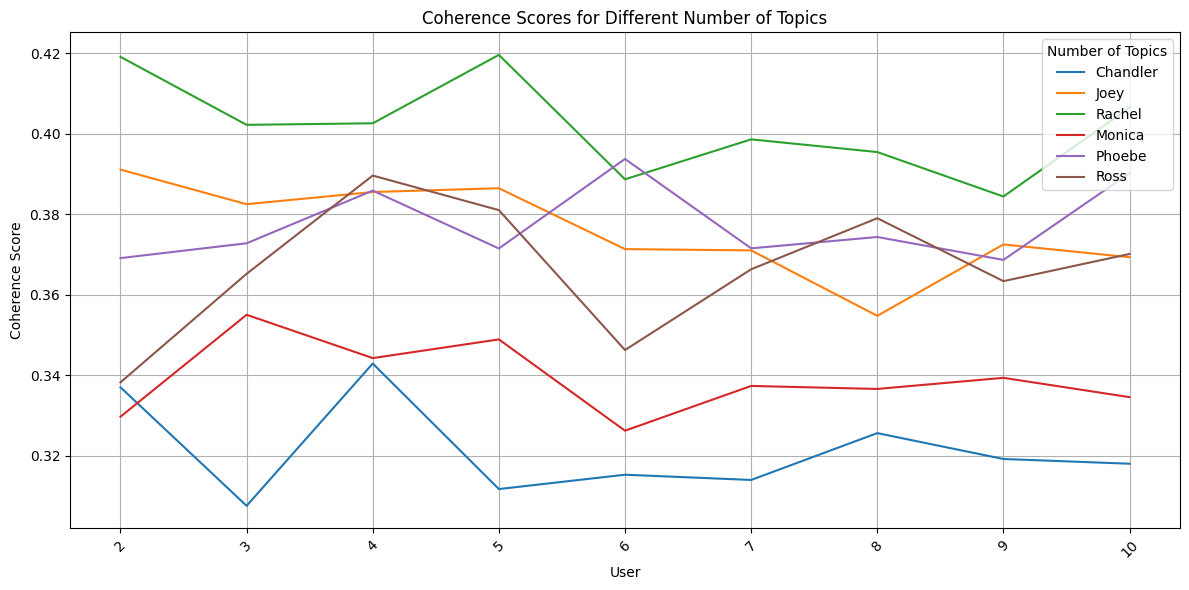

Topic 1 --> 0.032*"you" + 0.026*"i" + 0.023*"no" + 0.022*"what" + 0.018*"that" + 0.016*"it" + 0.014*"oh" + 0.014*"on" + 0.014*"okay" + 0.012*"me"
Topic 2 --> 0.045*"i" + 0.036*"you" + 0.018*"it" + 0.015*"yeah" + 0.013*"this" + 0.012*"on" + 0.012*"she" + 0.011*"that" + 0.009*"have" + 0.009*"can"
Topic 3 --> 0.041*"i" + 0.026*"you" + 0.015*"we" + 0.015*"it" + 0.012*"no" + 0.011*"m" + 0.011*"have" + 0.010*"that" + 0.010*"do" + 0.010*"okay"
Topic 4 --> 0.054*"i" + 0.046*"you" + 0.016*"it" + 0.014*"me" + 0.013*"that" + 0.013*"hey" + 0.012*"was" + 0.012*"just" + 0.012*"of" + 0.011*"well"


In [ ]:
all_coherences_df = pd.DataFrame(all_coherences).T
all_coherences_df.columns = list(range(2, len(all_coherences_df.columns) + 2))  # Renaming columns to topic numbers

all_coherences_df = all_coherences_df.T

# Plotting
all_coherences_df.plot(kind='line', figsize=(12, 6))
plt.title('Coherence Scores for Different Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Number of Topics')
plt.grid()
plt.show()

for topic, l in best_topics_dict['Ross'].items():
    l = l[1]
    print(f"{topic} --> {l}")


### Task 3
We want to test whether some emotion patterns are occurring with some particular personality trait. For this purpose, we use the NRC emotion dataset where around 20K words have been assigned values for valence, arousal and dominance (VAD) dimension, see EmotionDynamics/lexicons at master ·Priya22/EmotionDynamics · GitHub. Write a script that identifies NRC lexicon terms from dataframe of speaker and calculates the overage valence, arousal and dominance score normalized with respect to the total number of lexicon terms in the dataframe, as well the corresponding standard deviations, minimum and maximum value. Comment whether some valence, arousal, dominance values provide insights to discriminate some personality traits.

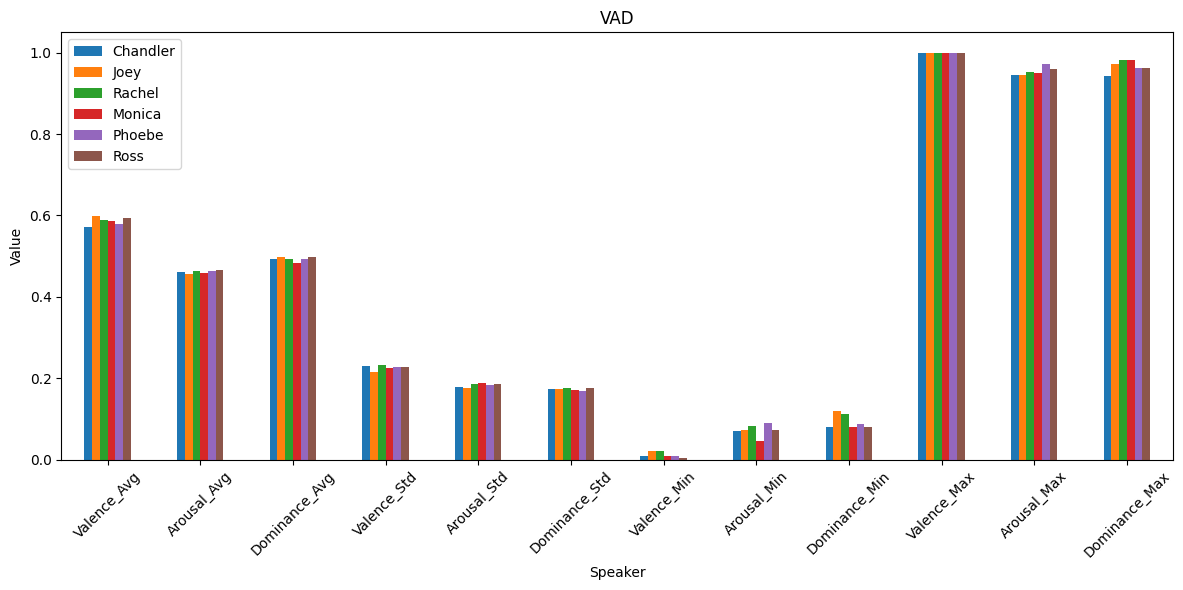

,Chandler,Joey,Rachel,Monica,Phoebe,Ross
Valence_Avg,0.570552,0.597765,0.588662,0.586088,0.578601,0.594269
Arousal_Avg,0.460898,0.455071,0.462931,0.459250,0.463010,0.466469
Dominance_Avg,0.491756,0.498987,0.491867,0.482580,0.491933,0.498248
Valence_Std,0.230104,0.214599,0.232786,0.224799,0.228719,0.227315
Arousal_Std,0.178745,0.175974,0.186783,0.187390,0.184041,0.186104
Dominance_Std,0.174659,0.172411,0.175200,0.172099,0.168369,0.175508
Valence_Min,0.010000,0.020000,0.020000,0.010000,0.010000,0.005000
Arousal_Min,0.071000,0.073000,0.082000,0.046000,0.090000,0.073000
Dominance_Min,0.081000,0.120000,0.113000,0.081000,0.087000,0.081000
Valence_Max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
vad_dataset = pd.read_csv("NRC_EmoLex_NRC-VAD-Lexicon.txt", sep='\t', header=None, names=['Word', 'Valence', 'Arousal', 'Dominance'])

vad_results = {}

def calculate_vad_statistics(speaker, speaker_df):
    all_tokens = [token for tokens in speaker_df['Tokens'] for token in tokens]
    
    # Filter the VAD dataset to get only the terms present in the speaker's tokens
    speaker_terms = vad_dataset[vad_dataset['Word'].isin(all_tokens)]
    
    vad_results[speaker] = {
        'Valence_Avg': speaker_terms['Valence'].mean(),
        'Arousal_Avg': speaker_terms['Arousal'].mean(),
        'Dominance_Avg': speaker_terms['Dominance'].mean(),
        'Valence_Std': speaker_terms['Valence'].std(),
        'Arousal_Std': speaker_terms['Arousal'].std(),
        'Dominance_Std': speaker_terms['Dominance'].std(),
        'Valence_Min': speaker_terms['Valence'].min(),
        'Arousal_Min': speaker_terms['Arousal'].min(),
        'Dominance_Min': speaker_terms['Dominance'].min(),
        'Valence_Max': speaker_terms['Valence'].max(),
        'Arousal_Max': speaker_terms['Arousal'].max(),
        'Dominance_Max': speaker_terms['Dominance'].max(),
        # 'Num_Lexicon_Terms': speaker_terms.shape[0]
    }

for speaker, speaker_df in speaker_dfs.items():
    calculate_vad_statistics(speaker, speaker_df)


vad_results_df = pd.DataFrame(vad_results)
vad_results_df.plot(kind='bar', figsize=(12, 6))
plt.title('VAD')
plt.ylabel('Value')
plt.xlabel('Speaker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

vad_results_df

# Task 4
In Task 4, we focus on segmenting the dataset according to the dominant personality trait of each speaker. This segmentation process allows us to analyze language patterns specific to each personality type within the OCEAN model—Openness, Conscientiousness, Extraversion, Agreeableness, and Emotional Stability.

Step 1: Segmenting Data by Dominant Personality Trait
First, we divide the data based on each speaker’s dominant trait. This segmentation groups the dataset into distinct subsets, each representing individuals who share the same prominent personality trait. This setup enables us to compare language patterns across different personality types and observe any distinct linguistic behaviors associated with each trait.

Step 2: Linguistic Feature Analysis
Following segmentation, we perform a series of linguistic analyses similar to those conducted in Task 1. For each personality-based subset, we extract the following linguistic features:

- Vocabulary Size – The diversity of words used by speakers within each personality group.
- Total Token Count – The total number of words or tokens, providing a measure of verbosity.
- Confirmation Frequency – The frequency of words or phrases indicating agreement or affirmation.
- Negation Frequency – The frequency of words or phrases indicating disagreement or negation.
- Repetition Frequency – The rate at which words or phrases are repeated, indicating emphasis or habitual patterns.

Step 3: Tracking Linguistic Feature Evolution
To gain deeper insights into the linguistic behavior of each personality group, we track the evolution of confirmation, negation, and repetition frequencies over time. By plotting these metrics separately for each personality trait, we can visualize and analyze changes in these features throughout the dataset.

Step 4: Generating Subgraphs for Each Personality Type
Finally, we generate subgraphs to represent the evolution of confirmation frequency, negation frequency, and repetition frequency for each personality type individually. These visualizations highlight trends and fluctuations within each personality group, making it easier to identify any patterns or tendencies that distinguish one personality type from another.

In [ ]:
import numpy as np
import ast

# Define a function to extract the dominant personality
def get_dominant_personality(row):

    trait_probabilities = ast.literal_eval(row['Personality'])
    max_trait_index = np.argmax(trait_probabilities)
    
    return max_trait_index


df['Dominant Personality'] = df.apply(get_dominant_personality, axis=1)


print(df['Dominant Personality'].value_counts())

# Convert the values in the 'Dominant Personality' column to int and store them in a list
dominant_personalities = df['Dominant Personality'].tolist()
dominant_personalities = [int(x) for x in dominant_personalities]

print(dominant_personalities)


Dominant Personality
0    5387
1    1123
Name: count, dtype: int64
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
import pandas as pd

personality_dfs = {}
for personality in df['Dominant Personality'].unique():
    personality_dfs[personality] = df[df['Dominant Personality'] == personality]


for personality, dataframe in personality_dfs.items():
    print(f"Dominant Personality {personality}:")
    print(dataframe.head())


Dominant Personality 0:
  Speaker_1        Speaker_2                         Personality  \
0  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
1  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
2  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
3  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
4  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   

                                         Utterance_1  \
0  also I was the point person on my company s tr...   
1                            That I did. That I did.   
2                             My duties?  All right.   
3                                             I see.   
4                                      Good to know.   

                                         Utterance_2              Utterance_3  \
0                   You must ve had your hands full.  That I did. That I did.   
1      So let s talk a little bit about your duties.   My duties?  A

C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Tokens'] = all_tokens
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Token Size'] = token_sizes
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

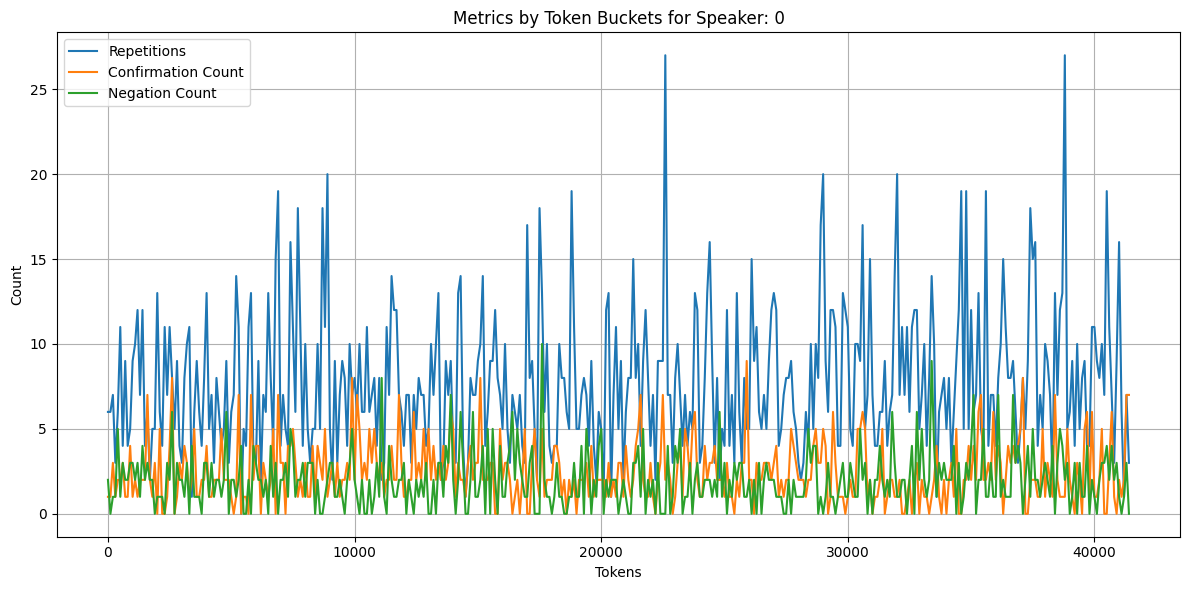

C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Tokens'] = all_tokens
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Token Size'] = token_sizes
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

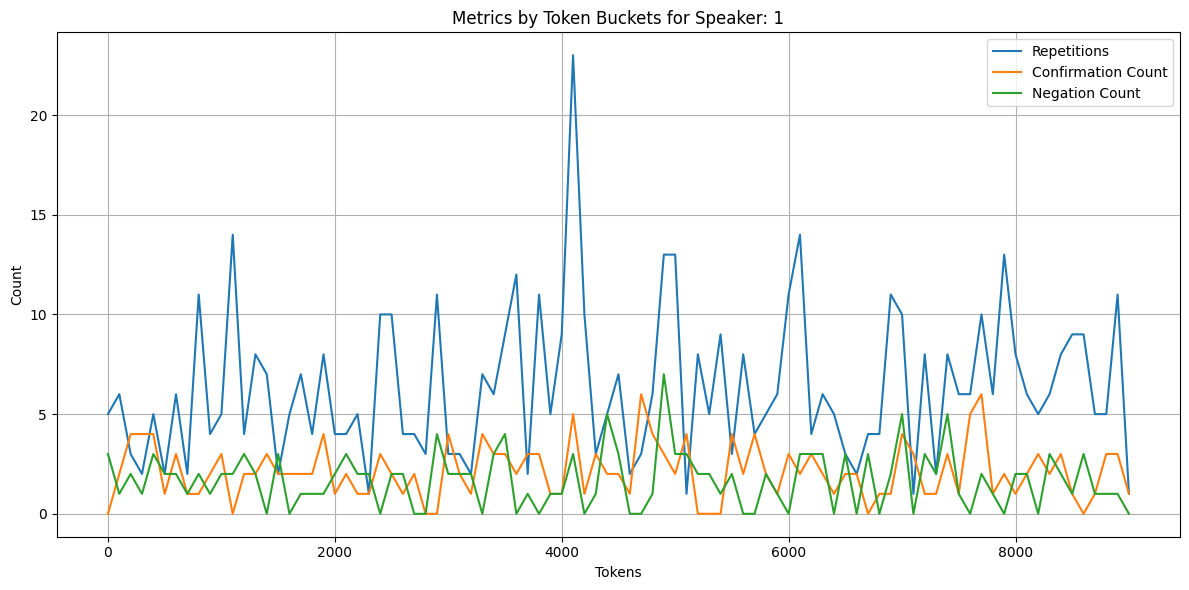

In [ ]:
all_metrics = {}
all_personality_averages = {}

for speaker, speaker_df in personality_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_metrics = pd.DataFrame(all_metrics).T

In [ ]:
df_metrics

,Vocabulary Size,Total Tokens,Total Repetitions,Total Confirmations,Total Negations
0,4022,41430,3234,1011,821
1,1621,9018,576,194,154


# Task 5
In Task 5, we conduct a personality analysis by comparing each speaker’s language to predefined personality traits using doc2vec embeddings and cosine similarity. This approach enables us to quantify how each speaker’s language reflects the OCEAN personality model.

Step 1: Training the doc2vec Model
First, we train a doc2vec model on the dataset using each speaker's utterances. This model learns a high-dimensional embedding space, which we then use to generate a unique vector for each speaker by compiling all their utterances into a single document.

Step 2: Generating Personality Trait Embeddings
Using a predefined personality dictionary aligned with OCEAN traits, we calculate embeddings for each trait. Each trait is represented by two embeddings: one for the positive aspect (e.g., sociability for Extraversion) and one for the negative aspect (e.g., reclusiveness for Extraversion).

Step 3: Calculating Similarity Scores
To evaluate how closely each speaker aligns with each personality trait, we calculate cosine similarity between the speaker's embedding and the positive and negative embeddings for each trait. This similarity score provides an indication of each speaker’s alignment with both ends of the personality spectrum.

Step 4: Experimental Variations with Personality Dictionaries
To test the robustness of this approach, we conduct the analysis twice: once using a basic dictionary and once with an extended dictionary that includes additional related terms. By comparing the results, we assess how dictionary scope influences the accuracy and interpretability of the model’s personality predictions.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

combined_texts = {speaker: " ".join(speaker_df['Utterance_1'].tolist()) for speaker, speaker_df in speaker_dfs.items()}
documents = [TaggedDocument(words=text.split(), tags=[speaker]) for speaker, text in combined_texts.items()]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

def generate_embedding(text):
    return model.infer_vector(text.split())


personality_definitions = {
    'Extraversion': [('Talkative', 'Silent'), ('Sociable', 'Reclusive'), ('Adventurous', 'Cautious'), ('Open', 'Secretive')],
    'Agreeableness': [('Good-natured', 'Irritable'), ('Cooperative', 'Negativistic'), ('Mild', 'Headstrong'), ('Not jealous', 'Jealous')],
    'Conscientiousness': [('Responsible', 'Undependable'), ('Scrupulous', 'Unscrupulous'), ('Persevering', 'Quitting'), ('Fussy', 'Careless')],
    'Emotional Stability': [('Calm', 'Anxious'), ('Composed', 'Excitable'), ('Not hypochondriacal', 'Hypochondriacal'), ('Poised', 'Nervous')],
    'Openness': [('Intellectual', 'Unreflective'), ('Artistic', 'Non-artistic'), ('Imaginative', 'Simple'), ('Polished', 'Crude')],
}


personality_embeddings = {
    trait: [(generate_embedding(positive), generate_embedding(negative)) for positive, negative in pairs]
    for trait, pairs in personality_definitions.items()
}


def compute_trait_position(dataframe_embedding, trait_embeddings):
    positions = []
    for pos_emb, neg_emb in trait_embeddings:
        pos_score = cosine_similarity([dataframe_embedding], [pos_emb])[0][0]
        neg_score = cosine_similarity([dataframe_embedding], [neg_emb])[0][0]
        position = pos_score -neg_score # Positive if closer to positive side, negative if closer to negative side
        positions.append(position)
    return np.mean(positions)  # Average position for the trait


import pandas as pd


table_data = {trait + '_Position': [] for trait in personality_definitions.keys()}
table_data['Speaker'] = []


for speaker, text in combined_texts.items():
    embedding = generate_embedding(text)
    table_data['Speaker'].append(speaker)
    

    for trait, trait_embeddings in personality_embeddings.items():
        position = compute_trait_position(embedding, trait_embeddings)
        table_data[f"{trait}_Position"].append(position)


df = pd.DataFrame(table_data).set_index('Speaker')
df


,Extraversion_Position,Agreeableness_Position,Conscientiousness_Position,Emotional Stability_Position,Openness_Position
Speaker,,,,,
Chandler,0.134872,0.292325,0.027881,0.461259,0.043549
Joey,0.058173,0.273819,0.142548,0.355033,0.055920
Rachel,0.153598,0.289202,-0.001692,0.370390,0.133818
Monica,0.229919,0.271048,0.082158,0.419097,0.015916
Phoebe,0.185089,0.285770,0.092128,0.345483,0.048203
Ross,0.119575,0.292070,0.037228,0.437279,0.139358


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


combined_texts = {speaker: " ".join(speaker_df['Utterance_1'].tolist()) for speaker, speaker_df in speaker_dfs.items()}


documents = [TaggedDocument(words=text.split(), tags=[speaker]) for speaker, text in combined_texts.items()]


model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)


def generate_embedding(text):
    return model.infer_vector(text.split())


personality_definitions = {
    'Extraversion': [
        ('Talkative', 'Quiet'), 
        ('Outgoing', 'Reserved'), 
        ('Energetic', 'Lethargic'), 
        ('Expressive', 'Unexpressive'),
        ('Assertive', 'Submissive'),
        ('Friendly', 'Aloof'),
        ('Sociable', 'Withdrawn')
    ],
    'Agreeableness': [
        ('Friendly', 'Hostile'), 
        ('Cooperative', 'Uncooperative'), 
        ('Compassionate', 'Apathetic'), 
        ('Forgiving', 'Vindictive'),
        ('Trusting', 'Suspicious'),
        ('Generous', 'Selfish'),
        ('Tolerant', 'Intolerant')
    ],
    'Conscientiousness': [
        ('Organized', 'Disorganized'), 
        ('Dependable', 'Unreliable'), 
        ('Diligent', 'Lazy'), 
        ('Thorough', 'Negligent'),
        ('Self-disciplined', 'Impulsive'),
        ('Detail-oriented', 'Careless'),
        ('Goal-focused', 'Aimless')
    ],
    'Emotional Stability': [
        ('Calm', 'Anxious'), 
        ('Stable', 'Unstable'), 
        ('Confident', 'Insecure'), 
        ('Relaxed', 'Stressed'),
        ('Optimistic', 'Pessimistic'),
        ('Resilient', 'Vulnerable'),
        ('Content', 'Discontented')
    ],
    'Openness': [
        ('Curious', 'Indifferent'), 
        ('Inventive', 'Conventional'), 
        ('Insightful', 'Shallow'), 
        ('Broad-minded', 'Narrow-minded'),
        ('Artistic', 'Unimaginative'),
        ('Intellectually adventurous', 'Cautious'),
        ('Appreciative of diversity', 'Conforming')
    ]
}


personality_embeddings = {
    trait: [(generate_embedding(positive), generate_embedding(negative)) for positive, negative in pairs]
    for trait, pairs in personality_definitions.items()
}


def compute_trait_position(dataframe_embedding, trait_embeddings):
    positions = []
    for pos_emb, neg_emb in trait_embeddings:
        pos_score = cosine_similarity([dataframe_embedding], [pos_emb])[0][0]
        neg_score = cosine_similarity([dataframe_embedding], [neg_emb])[0][0]
        position = pos_score -neg_score # Positive if closer to positive side, negative if closer to negative side
        positions.append(position)
    return np.mean(positions)  # Average position for the trait


import pandas as pd


table_data = {trait + '_Position': [] for trait in personality_definitions.keys()}
table_data['Speaker'] = []


for speaker, text in combined_texts.items():
    embedding = generate_embedding(text)
    table_data['Speaker'].append(speaker)
    

    for trait, trait_embeddings in personality_embeddings.items():
        position = compute_trait_position(embedding, trait_embeddings)
        table_data[f"{trait}_Position"].append(position)


df = pd.DataFrame(table_data).set_index('Speaker')
df


,Extraversion_Position,Agreeableness_Position,Conscientiousness_Position,Emotional Stability_Position,Openness_Position
Speaker,,,,,
Chandler,0.104897,-0.001111,0.061788,0.041357,0.140063
Joey,0.018014,0.036505,0.055300,0.103585,0.082392
Rachel,0.079220,0.039728,0.027634,0.073352,0.147012
Monica,0.059888,0.059699,0.028668,0.027082,0.167761
Phoebe,0.023426,0.040363,0.046659,0.088690,0.136026
Ross,0.052614,0.047678,0.008740,0.079503,0.120281


In [ ]:
import pandas as pd
import ast 

# Initialize a dictionary to store the speaker names and their personality traits
personality_data = {
    'Speaker': [],
    'Personality Trait 1': [],
    'Personality Trait 2': [],
    'Personality Trait 3': [],
    'Personality Trait 4': [],
    'Personality Trait 5': []
}

# Loop through each speaker and extract the values in the 'Personality' column
for speaker, speaker_df in speaker_dfs.items():

    if 'Personality' in speaker_df.columns and not speaker_df['Personality'].empty:

        first_personality_entry = speaker_df['Personality'].iloc[0]
        

        first_personality_list = ast.literal_eval(first_personality_entry)

        if isinstance(first_personality_list, list) and len(first_personality_list) >= 5:
            personality_data['Speaker'].append(speaker)

            for i in range(5):
                personality_data[f'Personality Trait {i + 1}'].append(first_personality_list[i])

personality_df = pd.DataFrame(personality_data)

personality_df


,Speaker,Personality Trait 1,Personality Trait 2,Personality Trait 3,Personality Trait 4,Personality Trait 5
0,Chandler,0.648,0.375,0.386,0.580,0.477
1,Joey,0.574,0.614,0.297,0.545,0.455
2,Rachel,0.635,0.354,0.521,0.552,0.469
3,Monica,0.713,0.457,0.457,0.660,0.511
4,Phoebe,0.600,0.480,0.310,0.460,0.560
5,Ross,0.722,0.489,0.600,0.533,0.356


# Task 6
## Create and split training/testing datasets

### Import frameworks

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Input
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Load Dataset and split labels

In [3]:
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)


labels = df['Personality'].to_numpy()
labels = [eval(x) for x in labels]
df_labels = pd.DataFrame(labels, columns=['Openness', 'Conscientiousness', 'Extroversion', 'Agreeableness', 'Neuroticism'])

### Function for creating training datasets with different variables

In [4]:
def get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(n_gram,n_gram))


    # Utterance 1 is always True
    utterance_tfidf = tfidf.fit_transform(df['Utterance_1'])
    df_features = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance1_{word}" for word in tfidf.get_feature_names_out()])
    if emotion:
        df_emotions = pd.get_dummies(df[['Emotion_1']])
        df_features = pd.concat([df_features, df_emotions], axis=1)
    if sentiment:
        df_sentiments = pd.get_dummies(df[['Sentiment_1']])
        df_features = pd.concat([df_features, df_sentiments], axis=1)



    if utterance_2:
        utterance_tfidf = tfidf.fit_transform(df['Utterance_2'])
        df_utterance_tfidf = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance2_{word}" for word in tfidf.get_feature_names_out()])
        df_features = pd.concat([df_features, df_utterance_tfidf], axis=1)
        if emotion:
            df_emotions = pd.get_dummies(df[['Emotion_2']])
            df_features = pd.concat([df_features, df_emotions], axis=1)
        if sentiment:
            df_sentiments = pd.get_dummies(df[['Sentiment_2']])
            df_features = pd.concat([df_features, df_sentiments], axis=1)


    if utterance_3:
        utterance_tfidf = tfidf.fit_transform(df['Utterance_3'])
        df_utterance_tfidf = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance3_{word}" for word in tfidf.get_feature_names_out()])
        df_features = pd.concat([df_features, df_utterance_tfidf], axis=1)
        if emotion:
            df_emotions = pd.get_dummies(df[['Emotion_3']])
            df_features = pd.concat([df_features, df_emotions], axis=1)
        if sentiment:
            df_sentiments = pd.get_dummies(df[['Sentiment_3']])
            df_features = pd.concat([df_features, df_sentiments], axis=1)

    # Train-test split
    features_train, features_test, labels_train, labels_test = train_test_split(df_features, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])

    return features_train, features_test, labels_train, labels_test

### Setup 5 different ai models to do parameter hypertuning with gridsearch on
This is so we can check which models performs best on our dataset, with several different parameters.

Note, for now we only use deep learning as this takes a long time to search, it is also unnecesary to hyper optimize for this assignment as the course is about Processing Natural Language


In [5]:

# Deep learning model function
def create_deep_learning_model(input_dim, dense_units=512, dropout_rate=0.5):
    model = Sequential([
        Input(shape=(input_dim,)),  # Define the input layer with the shape
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(5, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def grid_search_deep_learning(features_train, labels_train):
    model = KerasRegressor(
        model=create_deep_learning_model,
        input_dim=features_train.shape[1],
        verbose=0
    )
    
    # Define the param_grid with parameter names directly available in KerasRegressor
    param_grid = {
        'model__dense_units': [512, 256],
        'model__dropout_rate': [0.3, 0.5],
        'epochs': [10],
        'batch_size': [16, 32]
    }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Deep Learning Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_




# Polynomial regression model function
def grid_search_polynomial_regression(features_train, labels_train):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
    
    multi_target_poly = MultiOutputRegressor(model)  # Wrap in MultiOutputRegressor
    param_grid = {
        'estimator__poly__degree': [2, 3]  # Adjust the parameter for the pipeline
    }
    
    grid_search = GridSearchCV(estimator=multi_target_poly, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Polynomial Regression Params:", grid_search.best_params_)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# SVR model function
def grid_search_svr(features_train, labels_train):
    # Initialize SVR model
    model = SVR()
    
    # Define parameter grid
    param_grid = {
        'estimator__kernel': ['linear', 'rbf', 'poly'],
        'estimator__C': [0.1, 1, 10],
        'estimator__epsilon': [0.01, 0.1, 1]
    }
    
    # Use MultiOutputRegressor with GridSearchCV
    multi_target_svr = MultiOutputRegressor(model)
    grid_search = GridSearchCV(estimator=multi_target_svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    
    # Fit the model
    grid_search.fit(features_train, labels_train)
    
    print("Best SVR Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# Decision tree model function
def grid_search_decision_tree(features_train, labels_train):
    model = DecisionTreeRegressor()
    param_grid = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10, 16]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Decision Tree Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# Random forest model function
def grid_search_random_forest(features_train, labels_train):
    model = RandomForestRegressor()
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Random Forest Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_

### Run grid search on all models
Note, as specified earlier, there is not enough time for this task that doesn't contribute to the field of NLP.

Therefore, we comment it out for now.

In [6]:
#print(features_train.shape)

# # Polynomial regression model
# best_polynomial_model, best_params_poly, best_params_poly_repeat, best_score_poly = grid_search_polynomial_regression(features_train, labels_train)
# print(f"Best Polynomial Model: {best_polynomial_model}")
# print(f"Best Parameters (Polynomial Regression): {best_params_poly}")
# print(f"Repeated Best Parameters (Polynomial Regression): {best_params_poly_repeat}")
# print(f"Best Score (Polynomial Regression): {best_score_poly}")

# # for dataframe in df_features_array:

# # SVR model
# # Train-test split
# features_train, features_test, labels_train, labels_test = train_test_split(dataframe, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])
# best_svr_model, best_params_svr, best_params_svr_repeat, best_score_svr = grid_search_svr(features_train, labels_train)
# print(f"Best SVR Model: {best_svr_model}")
# print(f"Best Parameters (SVR): {best_params_svr}")
# print(f"Repeated Best Parameters (SVR): {best_params_svr_repeat}")
# print(f"Best Score (SVR): {best_score_svr}")

# # Decision tree model
# best_decision_tree_model, best_params_dt, best_params_dt_repeat, best_score_dt = grid_search_decision_tree(features_train, labels_train)
# print(f"Best Decision Tree Model: {best_decision_tree_model}")
# print(f"Best Parameters (Decision Tree): {best_params_dt}")
# print(f"Repeated Best Parameters (Decision Tree): {best_params_dt_repeat}")
# print(f"Best Score (Decision Tree): {best_score_dt}")

# # Random forest model
# best_random_forest_model, best_params_rf, best_params_rf_repeat, best_score_rf = grid_search_random_forest(features_train, labels_train)
# print(f"Best Random Forest Model: {best_random_forest_model}")
# print(f"Best Parameters (Random Forest): {best_params_rf}")
# print(f"Repeated Best Parameters (Random Forest): {best_params_rf_repeat}")
# print(f"Best Score (Random Forest): {best_score_rf}")

# # Deep learning model
# best_deep_learning_model, best_params_dl, best_params_dl_repeat, best_score_dl = grid_search_deep_learning(features_train, labels_train)
# print(f"Best Deep Learning Model: {best_deep_learning_model}")
# print(f"Best Parameters (Deep Learning): {best_params_dl}")
# print(f"Repeated Best Parameters (Deep Learning): {best_params_dl_repeat}")
# print(f"Best Score (Deep Learning): {best_score_dl}")

### Run grid search only one a deep learning model
Therefore we only run grid search on deep learning, and not all models

In [7]:
features_train, features_test, labels_train, labels_test = get_training_labels()


# Deep learning model
best_deep_learning_model, best_params_dl, best_params_dl_repeat, best_score_dl = grid_search_deep_learning(features_train, labels_train)
print(f"Best Deep Learning Model: {best_deep_learning_model}")
print(f"Best Parameters (Deep Learning): {best_params_dl}")
print(f"Repeated Best Parameters (Deep Learning): {best_params_dl_repeat}")
print(f"Best Score (Deep Learning): {best_score_dl}")

Best Deep Learning Params: {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}
Best Deep Learning Model: KerasRegressor(
	model=<function create_deep_learning_model at 0x000001DB6D5D9620>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	input_dim=12262
	model__dense_units=256
	model__dropout_rate=0.5
)
Best Parameters (Deep Learning): {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}
Repeated Best Parameters (Deep Learning): {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}
Best Score (Deep Learning): -0.005872741745173176


The best deep learning parameters for this problem are these:

batch_size: 32

epochs: 10

model__dense_units: 256

model__dropout_rate: 0.5

In [7]:
best_params = {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}

### Create a list of datasets that differs in simple terms
This is the meat of this task. We want to determine how different features affect the model.

Therefore we start by making only one or two changes in each dataset in order to be able to measure the impact of every single feature

In [8]:
training_datasets = {
    "all_data": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "5000features": list(get_training_labels(max_features=5000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "1000features": list(get_training_labels(max_features=1000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "bigram": list(get_training_labels(max_features=None, n_gram=2, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "trigram": list(get_training_labels(max_features=None, n_gram=3, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "quadgram": list(get_training_labels(max_features=None, n_gram=4, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "no_sentiment": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=False, utterance_2=True, utterance_3=True)),
    "no_emotion": list(get_training_labels(max_features=None, n_gram=1, emotion=False, sentiment=True, utterance_2=True, utterance_3=True)),
    "no_emotion_or_sentiment": list(get_training_labels(max_features=None, n_gram=1, emotion=False, sentiment=False, utterance_2=True, utterance_3=True)),

    "no_utterance2": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=False, utterance_3=True)),
    "only_utterance1": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=False, utterance_3=False))
}

### Create a function for running the model on all datasets
We split the 'train' into 'train/val', so that we have training, validation and testing

In [9]:
def run_deep_learning_model_with_params(features_train, features_test, labels_train, labels_test, params):
    # Extract parameters from the dictionary
    dense_units = params.get('model__dense_units', 512)
    dropout_rate = params.get('model__dropout_rate', 0.5)
    epochs = params.get('epochs', 10)
    batch_size = params.get('batch_size', 32)
    
    # Train-val split
    df_full_train, df_full_test, labels_train, labels_test = train_test_split(df, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])
    features_inner_train, features_val, labels_inner_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42, stratify=df_full_train['Speaker_1'])

    # Define the model architecture based on chosen parameters
    model = Sequential([
        Input(shape=(features_train.shape[1],)),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(5, activation='linear')  # Output layer for regression
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mape'])
    
    # Train the model
    history = model.fit(features_inner_train, labels_inner_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(features_val, labels_val),
                        verbose=1)
    
    # Evaluate the model on the test set
    test_mse, test_mae, test_mape = model.evaluate(features_test, labels_test)
    
    return test_mse, test_mae, test_mape

### Run the model on every dataset to compare test mean square error

In [ ]:
test_losses = {}

# Loop through each dataset in training_datasets
for dataset_name, (features_train, labels_train, features_test, labels_test) in training_datasets.items():
    print(f"Model: {dataset_name}")
    
    test_mse, test_mae, test_mape = run_deep_learning_model_with_params(features_train, labels_train, features_test, labels_test, best_params)
    
    test_losses[dataset_name] = [test_mse, test_mae, test_mape]
    print(f"{dataset_name}:")
    print(f"Mean Squared Error: {test_mse}")
    print(f"Mean Absolute Error: {test_mae}")
    print(f"Mean Absolute Percentage Error: {test_mape}")


Model: all_data
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0554 - mae: 0.1728 - mape: 34.4814 - val_loss: 0.0071 - val_mae: 0.0679 - val_mape: 14.1835
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0088 - mae: 0.0752 - mape: 15.5987 - val_loss: 0.0076 - val_mae: 0.0714 - val_mape: 14.4054
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0069 - mae: 0.0661 - mape: 13.6445 - val_loss: 0.0064 - val_mae: 0.0634 - val_mape: 13.2364
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0049 - mae: 0.0558 - mape: 11.5159 - val_loss: 0.0066 - val_mae: 0.0634 - val_mape: 12.8835
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0033 - mae: 0.0458 - mape: 9.4348 - val_loss: 0.0063 - val_mae: 0.0622 - val_mape: 12.8447
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0025 - mae: 0.0390 - mape: 8.0411 - val_loss: 0.0060 - val_mae: 0.0597 - val_mape: 12.4248
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - l

In [21]:
# Print test losses sorted by each metric from least to most loss
metrics = ["Mean Squared Error", "Mean Absolute Error", "Mean Absolute Percentage Error"]

for i in range(3):
    print(f"\nTest Losses sorted by {metrics[i]} (sorted):")
    for dataset, loss in sorted(test_losses.items(), key=lambda item: item[1][i]):
        print(f"{dataset}: {loss[i]}")


Test Losses sorted by Mean Squared Error (sorted):
5000features: 0.00571276992559433
trigram: 0.005729729309678078
quadgram: 0.005730041302740574
no_emotion: 0.005732996389269829
no_sentiment: 0.005785708781331778
bigram: 0.005821918603032827
all_data: 0.00585175072774291
1000features: 0.0059440056793391705
no_utterance2: 0.005988821387290955
no_emotion_or_sentiment: 0.00603902991861105
only_utterance1: 0.006119111552834511

Test Losses sorted by Mean Absolute Error (sorted):
trigram: 0.05766170471906662
5000features: 0.05788521096110344
no_emotion: 0.05790345370769501
quadgram: 0.05791456997394562
no_sentiment: 0.05831199511885643
bigram: 0.05843406170606613
all_data: 0.05871236324310303
no_emotion_or_sentiment: 0.0591922253370285
1000features: 0.059513580054044724
no_utterance2: 0.05992359668016434
only_utterance1: 0.06029250845313072

Test Losses sorted by Mean Absolute Percentage Error (sorted):
trigram: 12.133415222167969
5000features: 12.178739547729492
no_sentiment: 12.22558212

### Datasets comparison

The test losses, ordered from least loss to most loss with MSE, are as follows:

- trigram:                  0.005757459439337254
- 5000features:             0.005766735412180424
- no_emotion:               0.005812237039208412
- quadgram:                 0.0058181206695735455
- no_emotion_or_sentiment:  0.005820064339786768
- all_data:                 0.0058225891552865505
- no_utterance2:            0.005976484622806311
- 1000features:             0.006012726575136185
- bigram:                   0.006078173406422138
- no_sentiment:             0.0061368318274617195
- only_utterance1:          0.00617994274944067


Let's break these down

The baseline is 'all_data' as that is just the raw dataset, so we use this to compare the changes with.

#### Limited Vocabulary 
Limiting it to 5000 features is very roughly limiting it to slightly above half. This did make a noticeable improvement.

Limiting the vocabulary to 1000 seemed to make the model worse.

This seems to indicate that the least frequent words yields too little information about personality, relative to more frequent words. But you might only want to cut off a certain bottom percentile.

We should test with a broader vocabulary and also somewhere between 1000-5000

Let's make a test for both 3000 and 7000


#### N-Gram
Trigram made a noticeable improvement over bigram, quadgram, and unigram.

This might indicate that trigram is optimal in capturing the personality of a speaker, as it hits a middleground of splitting up tokens.


#### Emotion
The emotion tags seems to not make a noticeable difference.


#### Sentiment
Removing sentiment seems to be detrimental to the model, however, if you remove both emotions and sentiment, then the performance goes back to baseline.

We can speculate on why this is the case.

There might be information in sentiment that only makes sense to the model together with emotion.


#### Utterances
It makes intuitive sense that removing utterance 3 (Speaker 1's second utterance) makes the model worse.

However, it is interesting that utterance 2 (Speaker 2's utterance) contributes to the models performance when combined with utterance 3

In [ ]:
def get_trained_deep_learning_model(features_train, features_test, labels_train, labels_test, params):
    # Extract parameters from the dictionary
    dense_units = params.get('model__dense_units', 512)
    dropout_rate = params.get('model__dropout_rate', 0.5)
    epochs = params.get('epochs', 10)
    batch_size = params.get('batch_size', 32)
    
    # Split the training set into inner train and validation sets
    features_inner_train, features_val, labels_inner_train, labels_val = train_test_split(
        features_train, labels_train, test_size=0.2, random_state=42
    )

    model = Sequential([
        Input(shape=(features_train.shape[1],)),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(5, activation='linear')  # Output layer for regression
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    history = model.fit(features_inner_train, labels_inner_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(features_val, labels_val),
                        verbose=1)
    
    # Evaluate the model on the test set
    test_mse = model.evaluate(features_test, labels_test)
    
    # Get predictions on the test set
    predictions = model.predict(features_test)
    predictions_df = pd.DataFrame(predictions, columns=['Openness', 'Conscientiousness', 'Extroversion', 'Agreeableness', 'Neuroticism'])

    return model, predictions_df, predictions, test_mse

In [25]:
features_train, features_test, labels_train, labels_test = get_training_labels(max_features=None, n_gram=3, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)

model, predictions_df, predictions, test_mse = get_trained_deep_learning_model(features_train, features_test, labels_train, labels_test, best_params)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - loss: 0.0577 - val_loss: 0.0082
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0140 - val_loss: 0.0078
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - loss: 0.0048 - val_loss: 0.0066
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0033 - val_loss: 0.0063
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - loss: 0.0013 - val_loss: 0.0057
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [26]:
predictions_df

,Openness,Conscientiousness,Extroversion,Agreeableness,Neuroticism
0,0.642563,0.434272,0.436069,0.544502,0.459863
1,0.640505,0.448235,0.431058,0.539055,0.466915
2,0.646487,0.416012,0.462487,0.545415,0.454876
3,0.629029,0.442529,0.404762,0.538429,0.484946
4,0.633427,0.450156,0.404736,0.547887,0.475493
...,...,...,...,...,...
1297,0.647931,0.436328,0.452903,0.551439,0.451657
1298,0.643767,0.437356,0.444447,0.543862,0.456912
1299,0.655952,0.441974,0.464712,0.547514,0.444190
1300,0.575739,0.585708,0.290997,0.505906,0.467162


In [27]:
labels_test

,Openness,Conscientiousness,Extroversion,Agreeableness,Neuroticism
2133,0.648,0.375,0.386,0.580,0.477
2391,0.648,0.375,0.386,0.580,0.477
2252,0.574,0.614,0.297,0.545,0.455
3531,0.635,0.354,0.521,0.552,0.469
1848,0.722,0.489,0.600,0.533,0.356
...,...,...,...,...,...
2630,0.600,0.480,0.310,0.460,0.560
2505,0.713,0.457,0.457,0.660,0.511
4002,0.713,0.457,0.457,0.660,0.511
457,0.574,0.614,0.297,0.545,0.455


In [28]:
df_full_train, df_full_test, labels_train, labels_test = train_test_split(df, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])
df_full_test

,Speaker_1,Speaker_2,Personality,Utterance_1,Utterance_2,Utterance_3,Emotion_1,Emotion_2,Emotion_3,Sentiment_1,Sentiment_2,Sentiment_3
2133,Chandler,Monica,"[0.648, 0.375, 0.386, 0.58, 0.477]",Here just take this.,That's stealing!,"No, we'll-we'll bring it back! Just put it und...",neutral,sadness,neutral,neutral,negative,neutral
2391,Chandler,Monica,"[0.648, 0.375, 0.386, 0.58, 0.477]",What!?,This was fun! But I've got an invasive vaginal...,"I'd love to stay, but I have eh... got a h...",surprise,joy,joy,positive,positive,positive
2252,Joey,Ross,"[0.574, 0.614, 0.297, 0.545, 0.455]",But the audition s in a couple hours and I don...,Well do you want some help?,Oh really? That d be great! You guys can be th...,fear,neutral,surprise,negative,neutral,positive
3531,Rachel,Ross,"[0.635, 0.354, 0.521, 0.552, 0.469]","Hi. Umm, I think there s something that we re...",I think we do. Why don t we go inside? Look u...,You do?,joy,sadness,surprise,positive,negative,positive
1848,Ross,Phoebe,"[0.722, 0.489, 0.6, 0.533, 0.356]",What?! No!,Well okay but I have two tickets to the ballro...,"Look, I don t think so Pheebs. All right, I l...",surprise,neutral,neutral,positive,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
2630,Phoebe,Rachel,"[0.6, 0.48, 0.31, 0.46, 0.56]","Um, um, Rachel can we talk for a sec?","Well, sure...just a sec, though, 'cause Paolo'...","Oh! Ok, um, ok, um,",neutral,neutral,fear,neutral,neutral,negative
2505,Monica,Gary,"[0.713, 0.457, 0.457, 0.66, 0.511]","Umm, listen I am sorry, but I ll put some out ...","Well okay, I ll swing by later. Do you live in...",Um-hmm.,sadness,neutral,neutral,negative,neutral,neutral
4002,Monica,Joey,"[0.713, 0.457, 0.457, 0.66, 0.511]","Y'know, I love doing crossword puzzles with yo...","Aww, me too. Now let's finish this and go to bed.","Okay! There's only one left, three letter word...",joy,joy,neutral,positive,positive,neutral
457,Joey,Chandler,"[0.574, 0.614, 0.297, 0.545, 0.455]",How'd you get to that?,"Well, I believe the piece of furniture was fin...",You knew about that?,anger,anger,surprise,negative,negative,positive


In [ ]:
def find_closest_personality(predictions, personalities, labels):
    closest_matches = []
    personalities_df = pd.DataFrame.from_dict(personalities, orient='index', columns=labels)

    for idx, pred in predictions.iterrows():
        # Calculate Euclidean distance to each personality
        distances = personalities_df.apply(lambda row: np.linalg.norm(pred - row), axis=1)
        
        # Find the personality with the smallest distance
        closest_personality = distances.idxmin()
        closest_distance = distances.min()
        
        closest_matches.append({
            "Prediction Index": idx,
            "Closest Personality": closest_personality,
            "Distance": closest_distance
        })
    
    return pd.DataFrame(closest_matches)


# These are the average personality scores calculated in an earlier task
personalities = {
    "Chandler": [0.648, 0.375, 0.386, 0.58, 0.477],
    "Joey": [0.574, 0.614, 0.297, 0.545, 0.455],
    "Monica": [0.713, 0.457, 0.457, 0.66, 0.511],
    "Phoebe": [0.6, 0.48, 0.31, 0.46, 0.56],
    "Rachel": [0.635, 0.354, 0.521, 0.552, 0.469],
    "Ross": [0.722, 0.489, 0.6, 0.533, 0.356]
}

trait_labels = ["Openness", "Conscientiousness", "Extroversion", "Agreeableness", "Neuroticism"]

closest_matches_df = find_closest_personality(predictions_df, personalities, trait_labels)


In [47]:
closest_matches_df

,Prediction Index,Closest Personality,Distance
0,0,Chandler,0.087198
1,1,Chandler,0.096063
2,2,Rachel,0.087430
3,3,Chandler,0.084044
4,4,Chandler,0.085120
...,...,...,...
1297,1297,Chandler,0.098464
1298,1298,Chandler,0.095035
1299,1299,Rachel,0.109465
1300,1300,Joey,0.050157


In [ ]:
def evaluate_personality_match(predictions, personalities, labels, actual_personalities):
    match_results = []
    
    
    personalities_df = pd.DataFrame.from_dict(personalities, orient='index', columns=labels)

    for idx, pred in predictions.iterrows():
        # Calculate Euclidean distance to each personality
        distances = personalities_df.apply(lambda row: np.linalg.norm(pred - row), axis=1)
        
        # Find the personality with the smallest distance
        closest_personality = distances.idxmin()
        closest_distance = distances.min()
        
        # Check if closest personality matches the actual personality in df_full_test['Speaker_1']
        actual_personality = actual_personalities.iloc[idx]
        is_match = closest_personality == actual_personality
        
        match_results.append({
            "Prediction Index": idx,
            "Closest Personality": closest_personality,
            "Actual Personality": actual_personality,
            "Distance": closest_distance,
            "Match": is_match
        })
    
    return pd.DataFrame(match_results)


trait_labels = ["Openness", "Conscientiousness", "Extroversion", "Agreeableness", "Neuroticism"]

match_df = evaluate_personality_match(predictions_df, personalities, trait_labels, df_full_test['Speaker_1'])

In [49]:
match_df

,Prediction Index,Closest Personality,Actual Personality,Distance,Match
0,0,Chandler,Chandler,0.087198,True
1,1,Chandler,Chandler,0.096063,True
2,2,Rachel,Joey,0.087430,False
3,3,Chandler,Rachel,0.084044,False
4,4,Chandler,Ross,0.085120,False
...,...,...,...,...,...
1297,1297,Chandler,Phoebe,0.098464,False
1298,1298,Chandler,Monica,0.095035,False
1299,1299,Rachel,Monica,0.109465,False
1300,1300,Joey,Joey,0.050157,True


In [42]:

match_counts = match_df['Match'].value_counts()

print("Match Counts:")
print(match_counts)

Match Counts:
Match
False    992
True     310
Name: count, dtype: int64


In [43]:
match_counts = match_df['Closest Personality'].value_counts()

print("Match Counts:")
print(match_counts)

Match Counts:
Closest Personality
Chandler    1050
Rachel       176
Ross          26
Phoebe        18
Monica        16
Joey          16
Name: count, dtype: int64


In [37]:
df_full_test

,Speaker_1,Speaker_2,Personality,Utterance_1,Utterance_2,Utterance_3,Emotion_1,Emotion_2,Emotion_3,Sentiment_1,Sentiment_2,Sentiment_3
2133,Chandler,Monica,"[0.648, 0.375, 0.386, 0.58, 0.477]",Here just take this.,That's stealing!,"No, we'll-we'll bring it back! Just put it und...",neutral,sadness,neutral,neutral,negative,neutral
2391,Chandler,Monica,"[0.648, 0.375, 0.386, 0.58, 0.477]",What!?,This was fun! But I've got an invasive vaginal...,"I'd love to stay, but I have eh... got a h...",surprise,joy,joy,positive,positive,positive
2252,Joey,Ross,"[0.574, 0.614, 0.297, 0.545, 0.455]",But the audition s in a couple hours and I don...,Well do you want some help?,Oh really? That d be great! You guys can be th...,fear,neutral,surprise,negative,neutral,positive
3531,Rachel,Ross,"[0.635, 0.354, 0.521, 0.552, 0.469]","Hi. Umm, I think there s something that we re...",I think we do. Why don t we go inside? Look u...,You do?,joy,sadness,surprise,positive,negative,positive
1848,Ross,Phoebe,"[0.722, 0.489, 0.6, 0.533, 0.356]",What?! No!,Well okay but I have two tickets to the ballro...,"Look, I don t think so Pheebs. All right, I l...",surprise,neutral,neutral,positive,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
2630,Phoebe,Rachel,"[0.6, 0.48, 0.31, 0.46, 0.56]","Um, um, Rachel can we talk for a sec?","Well, sure...just a sec, though, 'cause Paolo'...","Oh! Ok, um, ok, um,",neutral,neutral,fear,neutral,neutral,negative
2505,Monica,Gary,"[0.713, 0.457, 0.457, 0.66, 0.511]","Umm, listen I am sorry, but I ll put some out ...","Well okay, I ll swing by later. Do you live in...",Um-hmm.,sadness,neutral,neutral,negative,neutral,neutral
4002,Monica,Joey,"[0.713, 0.457, 0.457, 0.66, 0.511]","Y'know, I love doing crossword puzzles with yo...","Aww, me too. Now let's finish this and go to bed.","Okay! There's only one left, three letter word...",joy,joy,neutral,positive,positive,neutral
457,Joey,Chandler,"[0.574, 0.614, 0.297, 0.545, 0.455]",How'd you get to that?,"Well, I believe the piece of furniture was fin...",You knew about that?,anger,anger,surprise,negative,negative,positive


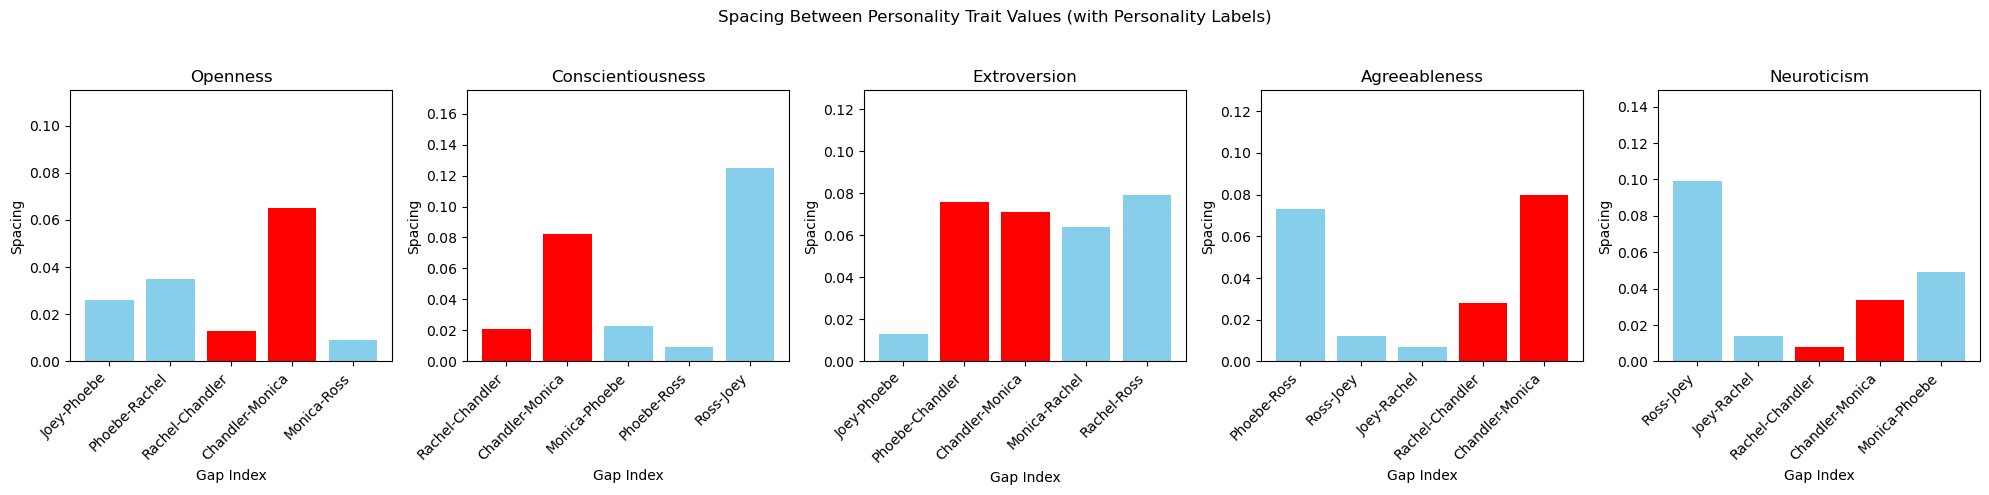

In [ ]:
def plot_trait_spacing_with_labels(personalities, highlight="Chandler"):
    # Convert personalities dictionary to DataFrame
    personalities_df = pd.DataFrame(personalities, index=["Openness", "Conscientiousness", "Extroversion", "Agreeableness", "Neuroticism"])
    
    # Store the spacing data and labels for plotting
    spacing_data = {}
    spacing_labels = {}

    # Loop through each trait and calculate spacing between sorted values
    for trait in personalities_df.index:
        # Sort the values and get corresponding personality names
        sorted_values = personalities_df.loc[trait].sort_values()
        sorted_personalities = sorted_values.index
        
        # Calculate the spacing (differences) between each successive value
        spacing = np.diff(sorted_values.values)
        spacing_data[trait] = spacing
        
        # Generate labels for each gap (who each gap is between)
        labels = [f"{sorted_personalities[i]}-{sorted_personalities[i+1]}" for i in range(len(sorted_personalities) - 1)]
        spacing_labels[trait] = labels

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
    fig.suptitle("Spacing Between Personality Trait Values (with Personality Labels)")

    for idx, (trait, spacing) in enumerate(spacing_data.items()):
        ax = axes[idx]
        
        # Assign colors, with red for bars involving the highlighted personality
        colors = ["red" if highlight in label else "skyblue" for label in spacing_labels[trait]]
        
        # Plot bars with designated colors
        ax.bar(range(len(spacing)), spacing, color=colors)
        ax.set_title(trait)
        ax.set_xlabel("Gap Index")
        ax.set_ylabel("Spacing")
        ax.set_ylim(0, max(spacing) + 0.05)
        
        # Set custom x-tick labels to show which personalities the gaps are between
        ax.set_xticks(range(len(spacing)))
        ax.set_xticklabels(spacing_labels[trait], rotation=45, ha="right")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
personalities = {
    "Chandler": [0.648, 0.375, 0.386, 0.58, 0.477],
    "Joey": [0.574, 0.614, 0.297, 0.545, 0.455],
    "Monica": [0.713, 0.457, 0.457, 0.66, 0.511],
    "Phoebe": [0.6, 0.48, 0.31, 0.46, 0.56],
    "Rachel": [0.635, 0.354, 0.521, 0.552, 0.469],
    "Ross": [0.722, 0.489, 0.6, 0.533, 0.356]
}

plot_trait_spacing_with_labels(personalities)